Python script that generates flow meter time series data with all your specified requirements. Here are the key features:

1. Generates 10,000 data points with 5-minute intervals
2. Implements a daily pattern where:

    * Flow is lowest during night/early morning
    * Increases during morning hours
    * Peaks between 1 PM and 3 PM
    * Gradually decreases in the evening

3. Normal flow range is 0-200 GPM
4. Near-zero readings (±1 GPM) for meter-off periods lasting 100+ points
5. Meter failure readings of 500 GPM lasting 50-100 points
6. Includes 0.5% outliers
7. Saves data to a CSV file with timestamp and flow rate columns

The code also includes:

* A daily pattern generation function
* Random variations to make the data more realistic
* Statistics about the generated data
* Sample day analysis showing peak and minimum flow times

In [7]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

def generate_daily_pattern(timestamp):
    """Generate daily pattern with peak between 1 PM and 3 PM"""
    hour = timestamp.hour
    # Base pattern peaks at 2 PM (hour 14)
    if 0 <= hour < 6:
        return 0.6  # Night/early morning (minimum flow)
    elif 6 <= hour < 10:
        return 0.7 + (hour - 6) * 0.05  # Morning ramp up
    elif 10 <= hour < 13:
        return 0.85 + (hour - 10) * 0.05  # Late morning to early afternoon
    elif 13 <= hour < 15:
        return 1.0  # Peak time (1 PM to 3 PM)
    elif 15 <= hour < 20:
        return 0.85 - (hour - 15) * 0.05  # Afternoon decline
    else:
        return 0.65  # Evening/night

def generate_flow_meter_data(n_points=10000, interval_minutes=5):
    # Set random seed for reproducibility
    np.random.seed(42)
    
    # Generate timestamps
    start_time = datetime(2024, 1, 1)
    timestamps = [start_time + timedelta(minutes=i*interval_minutes) for i in range(n_points)]
    
    # Create base flow data using daily pattern
    base_flows = []
    for ts in timestamps:
        daily_factor = generate_daily_pattern(ts)
        # Base flow with some random variation, centered higher to maintain minimum 100
        base_flow = daily_factor * 80 + 110 + np.random.normal(0, 5)
        base_flows.append(base_flow)
    
    # Convert to numpy array and clip between 100 and 200 for normal operation
    flow_data = np.clip(base_flows, 100, 200)
    
    # Create DataFrame
    df = pd.DataFrame({
        'timestamp': timestamps,
        'flow_rate': flow_data
    })
    
    # Add near-zero flow periods (100+ consecutive points)
    n_off_periods = np.random.randint(3, 6)  # 3-5 off periods
    for _ in range(n_off_periods):
        start_idx = np.random.randint(0, n_points - 150)
        duration = np.random.randint(100, 150)  # 100-149 points
        # Generate values near zero (±1)
        near_zero_values = np.random.uniform(-1, 1, duration)
        df.loc[start_idx:start_idx + duration - 1, 'flow_rate'] = near_zero_values
    
    # Add meter failure periods (500 readings for 50-100 consecutive points)
    n_failure_periods = np.random.randint(2, 4)  # 2-3 failure periods
    for _ in range(n_failure_periods):
        start_idx = np.random.randint(0, n_points - 101)
        duration = np.random.randint(50, 101)  # 50-100 points
        df.loc[start_idx:start_idx + duration - 1, 'flow_rate'] = 500
    
    # Add outliers (0.5% of data points)
    n_outliers = int(n_points * 0.005)  # 0.5% of points
    outlier_indices = np.random.choice(
        df.index[df['flow_rate'].between(100, 200)],  # Only select from normal readings
        size=n_outliers,
        replace=False
    )
    # Generate outliers between 220 and 250
    df.loc[outlier_indices, 'flow_rate'] = np.random.uniform(220, 250, n_outliers)
    
    return df

# Generate the data
flow_data = generate_flow_meter_data()

# Print basic statistics
print("\nDataset Statistics:")
print(f"Total points: {len(flow_data)}")
print(f"Number of near-zero readings (±1): {len(flow_data[abs(flow_data['flow_rate']) <= 1])}")
print(f"Number of failures (500): {len(flow_data[flow_data['flow_rate'] == 500])}")
print(f"Number of outliers (>200, <=250): {len(flow_data[(flow_data['flow_rate'] > 200) & (flow_data['flow_rate'] <= 250)])}")

# Calculate flow statistics for normal operation
normal_flow = flow_data[(flow_data['flow_rate'] > 1) & 
                       (flow_data['flow_rate'] <= 200) & 
                       (flow_data['flow_rate'] != 500)]
print("\nNormal Flow Statistics:")
print(f"Minimum normal flow: {normal_flow['flow_rate'].min():.2f}")
print(f"Maximum normal flow: {normal_flow['flow_rate'].max():.2f}")
print(f"Average normal flow: {normal_flow['flow_rate'].mean():.2f}")

# Calculate daily statistics for a sample day
sample_day = flow_data[flow_data['timestamp'].dt.date == flow_data['timestamp'].dt.date[0]]
print("\nSample Day Statistics:")
print(f"Peak flow time: {sample_day.loc[sample_day['flow_rate'].idxmax(), 'timestamp'].strftime('%H:%M')}")
print(f"Minimum flow time: {sample_day.loc[sample_day['flow_rate'].idxmin(), 'timestamp'].strftime('%H:%M')}")

# Save to CSV
_date = datetime.today() #create the date
_date =_date.strftime("%Y%m%d")

title = "simulated_data_daily_cyclical_basic_flow_meter_" + _date + ".csv"
flow_data.to_csv(title, index=False)
print("\nFirst few rows of the dataset:")
print(flow_data.head())



Dataset Statistics:
Total points: 10000
Number of near-zero readings (±1): 490
Number of failures (500): 267
Number of outliers (>200, <=250): 50

Normal Flow Statistics:
Minimum normal flow: 142.39
Maximum normal flow: 200.00
Average normal flow: 169.69

Sample Day Statistics:
Peak flow time: 22:45
Minimum flow time: 21:50

First few rows of the dataset:
            timestamp   flow_rate
0 2024-01-01 00:00:00  160.483571
1 2024-01-01 00:05:00  157.308678
2 2024-01-01 00:10:00  161.238443
3 2024-01-01 00:15:00  165.615149
4 2024-01-01 00:20:00  156.829233


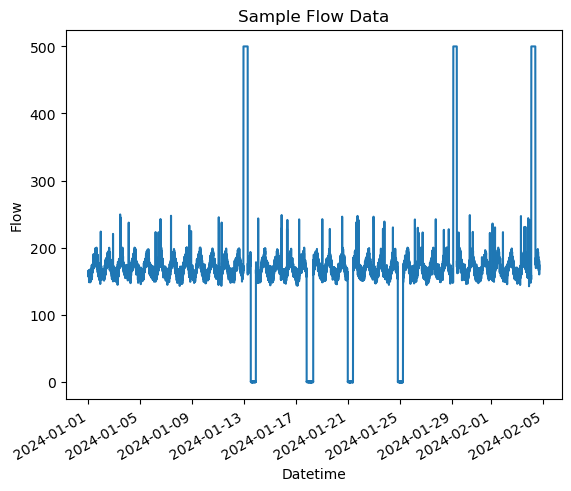

In [9]:
plt.plot(flow_data.timestamp, flow_data.flow_rate)

#add title and labels
plt.title("Sample Flow Data")
plt.xlabel("Datetime")
plt.ylabel("Flow")

#adjust ticks on x-axis for readability
plt.xticks(rotation=30, ha='right')
plt.show()